**Load all the features saved as numpy array**

In [ ]:
# Load the pre-extracted image features and question embeddings.
# This retrieves the saved feature arrays from the previous steps.
# Loading these features allows us to proceed with model training without re-extracting them.

train_features = np.load("train_features.npy")  # (num_train_samples, 2048)
val_features = np.load("val_features.npy")  # (num_val_samples, 2048)

map image feature for each question row to get the same sampled dataset

In [ ]:
# Map image features to each question row based on image ID.
# This ensures that each question in the filtered DataFrames is associated with its corresponding image features.
# It handles cases where the order of questions might not match the order of extracted image features.

#Load features from filtered image IDs
train_image_features = dict(zip(df_train_filtered['image_id'], train_features)) # Create a dictionary for train features
val_image_features = dict(zip(df_val_filtered['image_id'], val_features)) # Create a dictionary for val features

# Function to get the image feature for each question row
def get_image_features_for_questions(df, image_features_dict):
    image_features = []
    for img_id in df['image_id']:
        image_features.append(image_features_dict.get(img_id, np.zeros(2048)))  # Default to zero if missing
    return np.array(image_features)

# Get the image features for the filtered train and val question rows
train_image_features_for_questions = get_image_features_for_questions(df_train_filtered, train_image_features)
val_image_features_for_questions = get_image_features_for_questions(df_val_filtered, val_image_features)

# Print out the shapes to confirm they match the number of rows
print(f"Train Image Features Shape: {train_image_features_for_questions.shape}")
print(f"Val Image Features Shape: {val_image_features_for_questions.shape}")

Train Image Features Shape: (53389, 2048)
Val Image Features Shape: (26769, 2048)


In [ ]:
train_question_embeddings = np.load("bert_embeddings_train.npy")  # (num_train_samples, 768)
train_answers = np.load("train_answers.npy")

In [ ]:
val_question_embeddings = np.load("bert_embeddings_val.npy")  # (num_val_samples, 768)
val_answers = np.load("val_answers.npy")  # (num_val_samples, 181)

# Model Architectures and training


**Approach 1: Baseline Concatenation Model**

Feature Extraction: Extract 2048-D ResNet features and 768-D BERT embeddings.
Concatenation: Combine them into a single 2816-D vector.
Feed-Forward Layers: Pass through several Dense layers sequentially (with dropout) until the final classification layer (181 classes).
Approach #1 (Concatenation + Basic FC)
•	Simplicity: Straightforward to implement.
•	Limitations: Doesn’t explicitly learn the relative importance of each modality, and lacks skip connections for better gradient flow.


In [ ]:
# Prepare the input data by concatenating image features and question embeddings.
# This approach combines the visual and textual information into a single feature vector.
# This combined vector will be fed into a fully connected neural network for classification.

import numpy as np

# Concatenate Features (Train)
X_train_combined = np.hstack((train_question_embeddings, train_image_features_for_questions))  # (num_train_samples, 2816)
y_train = train_answers  # Labels remain the same

# Concatenate Features (Validation)
X_val_combined = np.hstack((val_question_embeddings, val_image_features_for_questions))  # (num_val_samples, 2816)
y_val = val_answers  # Labels remain the same

# Save the combined features
np.save("train_combined_features.npy", X_train_combined)
np.save("val_combined_features.npy", X_val_combined)

# Print shapes to verify
print("Train Combined Features Shape:", X_train_combined.shape)  # (num_train_samples, 2816)
print("Train Labels Shape:", y_train.shape)  # (num_train_samples, 181)

print("Validation Combined Features Shape:", X_val_combined.shape)  # (num_val_samples, 2816)
print("Validation Labels Shape:", y_val.shape)  # (num_val_samples, 181)


Train Combined Features Shape: (53389, 2816)
Train Labels Shape: (53389, 181)
Validation Combined Features Shape: (26769, 2816)
Validation Labels Shape: (26769, 181)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.2654 - loss: 3.3136 - val_accuracy: 0.3708 - val_loss: 2.2846
Epoch 2/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3427 - loss: 2.3881 - val_accuracy: 0.3859 - val_loss: 2.1557
Epoch 3/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3589 - loss: 2.2365 - val_accuracy: 0.3994 - val_loss: 2.0305
Epoch 4/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.3737 - loss: 2.1384 - val_accuracy: 0.4194 - val_loss: 1.9255
Epoch 5/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3936 - loss: 2.0332 - val_accuracy: 0.4296 - val_loss: 1.8473
Epoch 6/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3997 - loss: 1.9707 - val_accuracy: 0.4420 - val_loss: 1.7769
Epoch 7/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.4105 - loss: 1.8980 - val_accuracy: 0.4498 - val_loss: 1.7229
Epoch 8/10
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4207 - loss: 1.855

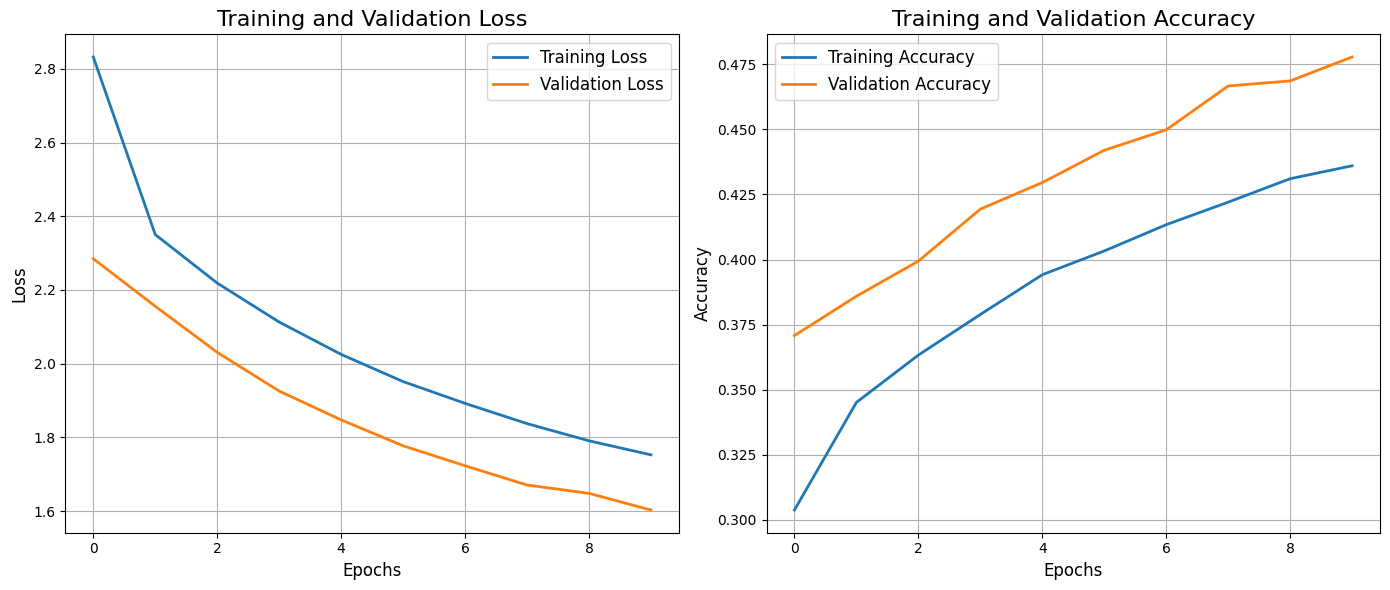

837/837 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4614 - loss: 1.6741

Approach 1 Validation Loss: 1.6026
Approach 1 Validation Accuracy: 0.4778


In [ ]:
# Define and train a simple fully connected neural network model.
# This model serves as a baseline by processing the concatenated features through dense layers.
# It uses ReLU activation and dropout for regularization, with a softmax output layer for classification.
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define a custom fully connected neural network model
model_approach1 = Sequential()

# Input layer
model_approach1.add(Dense(1024, input_dim=X_train_combined.shape[1], activation='relu'))  # First dense layer with ReLU activation
model_approach1.add(Dropout(0.5))  # Dropout to avoid overfitting

# Add another hidden layer
model_approach1.add(Dense(512, activation='relu'))
model_approach1.add(Dropout(0.5))

# Add another hidden layer
model_approach1.add(Dense(256, activation='relu'))
model_approach1.add(Dropout(0.5))

# Output layer (181 classes, softmax for multi-class classification)
model_approach1.add(Dense(181, activation='softmax'))

# Compile the model
model_approach1.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Print model summary
model_approach1.summary()

# Train the model
history_approach1 = model_approach1.fit(
    X_train_combined, y_train,  # Use combined features and labels
    validation_data=(X_val_combined, y_val),  # Validation data
    epochs=10,  # Specify the number of epochs
    batch_size=32,  # Adjust batch size as needed
    verbose=1  # To see progress during training
)

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_approach1.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_approach1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_approach1.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_approach1.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model on the validation set
val_loss_approach1, val_accuracy_approach1 = model_approach1.evaluate(X_val_combined, y_val, verbose=1)
print(f'\nApproach 1 Validation Loss: {val_loss_approach1:.4f}')
print(f'Approach 1 Validation Accuracy: {val_accuracy_approach1:.4f}')



Model Architecture Description (Approach 1):

This baseline model adopts a straightforward approach by concatenating the extracted image features (from ResNet50) and question embeddings (from BERT) into a single, larger feature vector. This combined vector is then passed through a series of fully connected (Dense) layers. Each hidden layer uses ReLU activation, introducing non-linearity, and is followed by a Dropout layer to mitigate overfitting. The final layer is a Dense layer with a softmax activation function, producing a probability distribution over the possible answer classes. This model is simple to implement but might not effectively capture the complex interactions between visual and textual modalities.

Hyperparameters Tuned (Approach 1):

Learning Rate: Set to 0.0001 for the Adam optimizer. This controls the step size during gradient descent. A smaller learning rate might lead to slower convergence but potentially better fine-tuning.
Number of Epochs: Set to 10. This determines how many times the entire training dataset is passed through the model. More epochs can lead to better learning but also risk overfitting.
Batch Size: Set to 32. This defines the number of samples processed in each mini-batch during training. It affects the speed of training and the stability of the gradient updates.
Number of Units in Dense Layers: The model uses 1024, 512, and 256 units in the hidden layers. These values determine the capacity of each layer to learn complex representations.
Dropout Rate: Set to 0.5 in each Dropout layer. This randomly sets a fraction of input units to 0 during training, preventing the model from relying too heavily on specific neurons and improving generalization.

## **Tuned Model**

Tuned Changes Summary
- Dropout: Reduced from 0.5 → 0.3 → Lower regularization pressure
- LeakyReLU Activation: Replaced standard ReLU with LeakyReLU to avoid "dead neurons" during training.
- Learning Rate Scheduling:  Added → Improves late-stage generalization
- Top-3 Accuracy:  Tracked top_3_accuracy → Captures near-miss predictions

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 1024)                │       2,884,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 181)                 │          46,517 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,587,253 (13.68 MB)

 Trainable params: 3,587,253 (13.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.2910 - loss: 5.4039 - top_3_accuracy: 0.5548 - val_accuracy: 0.3804 - val_loss: 3.8009 - val_top_3_accuracy: 0.6710 - learning_rate: 1.0000e-04
Epoch 2/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3611 - loss: 3.7246 - top_3_accuracy: 0.6653 - val_accuracy: 0.4131 - val_loss: 3.1476 - val_top_3_accuracy: 0.7142 - learning_rate: 1.0000e-04
Epoch 3/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3883 - loss: 3.1469 - top_3_accuracy: 0.6967 - val_accuracy: 0.4403 - val_loss: 2.7380 - val_top_3_accuracy: 0.7338 - learning_rate: 1.0000e-04
Epoch 4/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4061 - loss: 2.7863 - top_3_accuracy: 0.7173 - val_accuracy: 0.4479 - val_loss: 2.4779 - val_top_3_accuracy: 0.7490 - learning_rate: 1.0000e-04
Epoch 5/30
835/835 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4192 - loss: 2.5453 - top_3_accuracy: 0.7325 - val_accuracy: 0.4568 - val_loss: 2.3093 - val_

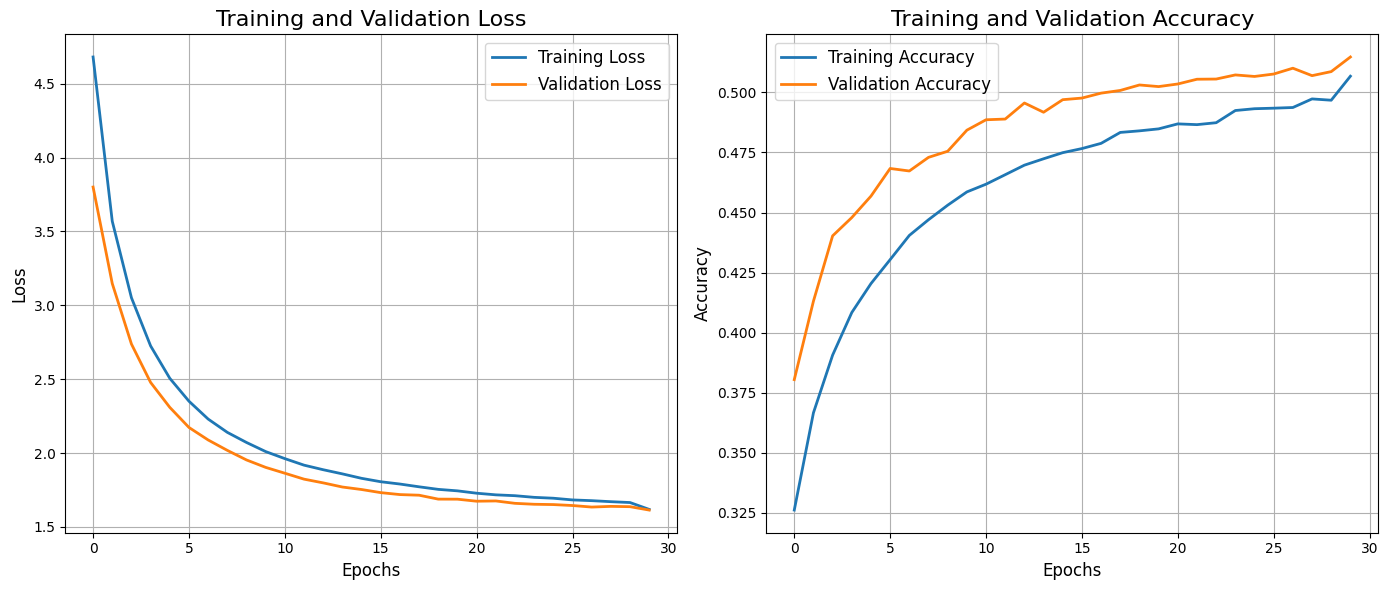

837/837 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5098 - loss: 1.6290 - top_3_accuracy: 0.8217

Approach 1 Validation Loss: 1.6139
Approach 1 Validation Accuracy: 0.5148
Approach 1 Top-3 Accuracy: 0.8246


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import TopKCategoricalAccuracy
import matplotlib.pyplot as plt

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Build the improved MLP model
model_approach1 = Sequential()

# Input layer
model_approach1.add(Dense(1024, input_dim=X_train_combined.shape[1], kernel_regularizer=l2(0.001)))
model_approach1.add(LeakyReLU(alpha=0.1))
model_approach1.add(Dropout(0.3))

# Hidden layer 1
model_approach1.add(Dense(512, kernel_regularizer=l2(0.001)))
model_approach1.add(LeakyReLU(alpha=0.1))
model_approach1.add(Dropout(0.3))

# Hidden layer 2
model_approach1.add(Dense(256, kernel_regularizer=l2(0.001)))
model_approach1.add(LeakyReLU(alpha=0.1))
model_approach1.add(Dropout(0.3))

# Output layer
model_approach1.add(Dense(181, activation='softmax'))

# Compile the model
model_approach1.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

# Print model summary
model_approach1.summary()

# Train the model
history_approach1 = model_approach1.fit(
    X_train_combined, y_train,
    validation_data=(X_val_combined, y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Plot training and validation loss and accuracy
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_approach1.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_approach1.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_approach1.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history_approach1.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model on the validation set
val_loss_approach1, val_accuracy_approach1, val_top3 = model_approach1.evaluate(X_val_combined, y_val, verbose=1)
print(f'\nApproach 1 Validation Loss: {val_loss_approach1:.4f}')
print(f'Approach 1 Validation Accuracy: {val_accuracy_approach1:.4f}')
print(f'Approach 1 Top-3 Accuracy: {val_top3:.4f}')
